In [1]:
import pandas as pd 
import numpy as np
import re

##LDA stuff
import gensim
from gensim.utils import simple_preprocess
import nltk
from nltk.corpus import words
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

##cleaning stuff
from sklearn.metrics.pairwise import cosine_similarity
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

import gensim.corpora as corpora
import pyLDAvis
import pyLDAvis.gensim
from gensim.models import CoherenceModel

##plotting
from matplotlib import pyplot as plt
from matplotlib import colors as mcolors
import seaborn as sns

In [2]:
def preprocess_text(text):
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word.isalnum()]
    tokens = [word.lower() for word in tokens]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return tokens

In [3]:
def preprocess(text):
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word.isalnum()]
    tokens = [word.lower() for word in tokens]
    return tokens

In [4]:
def remove_non_english_words(text, valid_words):
    tokens = word_tokenize(text)
    ans = [w for w in tokens if w.lower() in valid_words]
    return ' '.join(ans)

def remove_stopwords(text):
    tokens = word_tokenize(text)
    ans = [w for w in tokens if w.lower() not in stop_words]
    return ' '.join(ans)

In [5]:
df_ibis = pd.read_csv('../../../data/processed/cleaned_ibis-sg-bencoolen.csv')
df_boss = pd.read_csv('../../../data/processed/cleaned_hotel-boss.csv')
df_g = pd.read_csv('../../../data/processed/cleaned_hotel-G.csv')
df_village = pd.read_csv('../../../data/processed/cleaned_village-hotel-albert-court-by-far-east-hospitality.csv')
df_holiday = pd.read_csv('../../../data/processed/cleaned_holiday-inn-express-clarke-quay.csv')


df_combi = pd.concat([df_ibis, df_boss, df_g, df_village, df_holiday])

In [6]:
##filter for year >= 2015
df_filtered = df_combi[df_combi['year'] >= 2015]

##preprocess text
nltk.download('stopwords')
nltk.download('words')
# Get the list of valid English words
english_words = set(words.words())
# set stopwords
sw = stopwords.words('english')
sw.extend(['ibis', 'boss', 'village', 'ibis_bencoolen', 'bencoolen', 'albert', 'far_east', 'east_hospitality',
           'clarke', 'quay', 'express', 'clarke_quay', 'albert_court', 'court', 'clark', 'inn'])

stop_words = set(sw)
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to C:\Users\Chen
[nltk_data]     Wei\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to C:\Users\Chen
[nltk_data]     Wei\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


## Stem Review

In [7]:
df_filtered['stem_review'] = df_filtered['stem_review'].apply(remove_stopwords)
df_filtered['stem_review'] = df_filtered['stem_review'].apply(remove_non_english_words, valid_words=english_words)
df_filtered['stem_tokens'] = df_filtered['stem_review'].apply(preprocess)

In [8]:
##Generate LDA dictionary and corpus
pre_dict = corpora.Dictionary(df_filtered['stem_tokens'])
pre_corpus = [pre_dict.doc2bow(text) for text in df_filtered['stem_tokens']]

In [ ]:
## find best_coherence:
for i in range(2, 7):
    lda = gensim.models.ldamodel.LdaModel
    pre_ldamodel = lda(pre_corpus, num_topics=i, id2word=pre_dict, passes=15)
    
    precovid_coherence = CoherenceModel(model=pre_ldamodel, texts=df_filtered['stem_tokens'], dictionary=pre_dict, coherence='c_v')
    lda_coherence = precovid_coherence.get_coherence()
    print(f"The coherence score at topic {i} is {lda_coherence}")

In [9]:
## Use 5 topics as baseline
lda = gensim.models.ldamodel.LdaModel
ldamodel = lda(pre_corpus, num_topics=5, id2word=pre_dict, passes=15)

In [10]:
# For Pre-COVID
topics_pre_stem = ldamodel.show_topics(formatted=False, num_words=20)
data_flat_pre = [word for word_list in df_filtered['stem_tokens'] for word in word_list]

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_9076\1556627539.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df_plot.loc[df_plot.topic_id == i, 'word'], rotation=30, horizontalalignment='right')


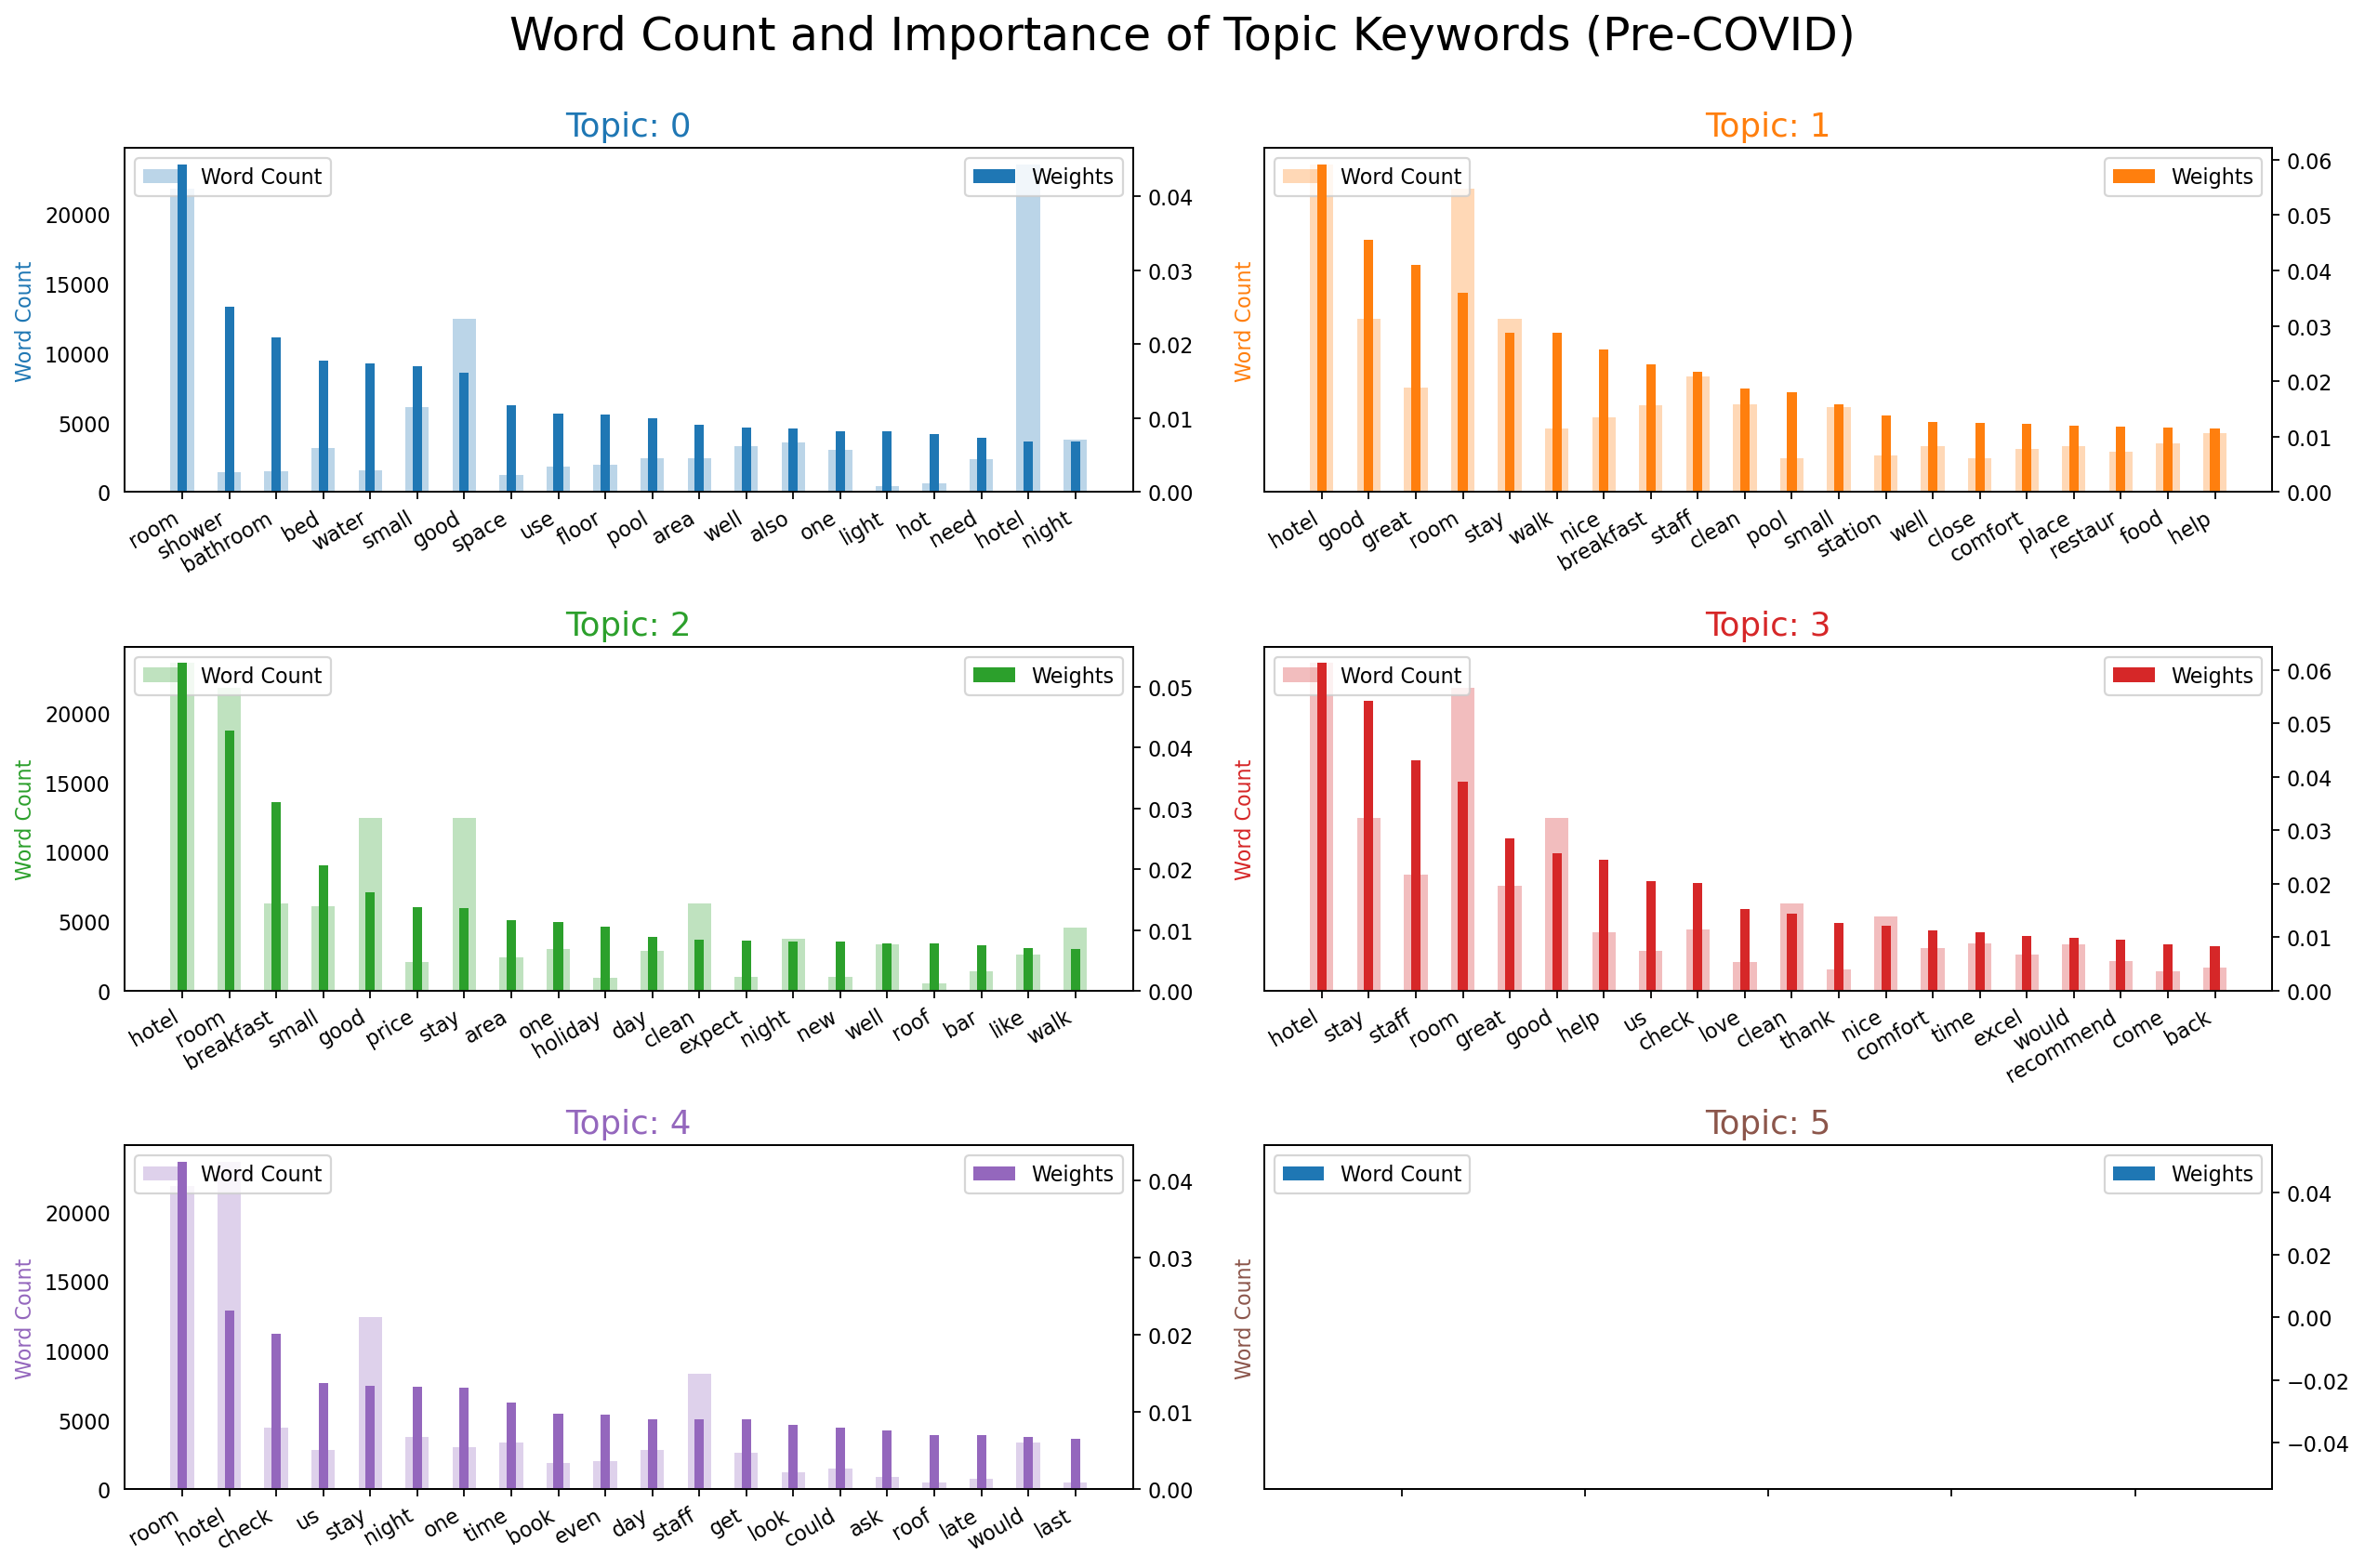

In [11]:
# Create a function to generate the plot
def plot_word_count_importance(topics, data_flat, title):
    out = []
    for i, topic in topics:
        for word, weight in topic:
            out.append([word, i, weight, data_flat.count(word)])

    df_plot = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])

    # Plot Word Count and Weights of Topic Keywords
    fig, axes = plt.subplots(3, 2, figsize=(16, 10), sharey=True, dpi=160)
    cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    for i, ax in enumerate(axes.flatten()):
        ax.bar(x='word', height='word_count', data=df_plot.loc[df_plot.topic_id == i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
        ax_twin = ax.twinx()
        ax_twin.bar(x='word', height='importance', data=df_plot.loc[df_plot.topic_id == i, :], color=cols[i], width=0.2, label='Weights')
        ax.set_ylabel('Word Count', color=cols[i])
        ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
        ax.tick_params(axis='y', left=False)
        ax.set_xticklabels(df_plot.loc[df_plot.topic_id == i, 'word'], rotation=30, horizontalalignment='right')
        ax.legend(loc='upper left')
        ax_twin.legend(loc='upper right')

    fig.tight_layout(w_pad=2)
    fig.suptitle(title, fontsize=22, y=1.05)
    plt.show()

# For Pre-COVID
plot_word_count_importance(topics_pre_stem, data_flat_pre, 'Word Count and Importance of Topic Keywords (Pre-COVID)')

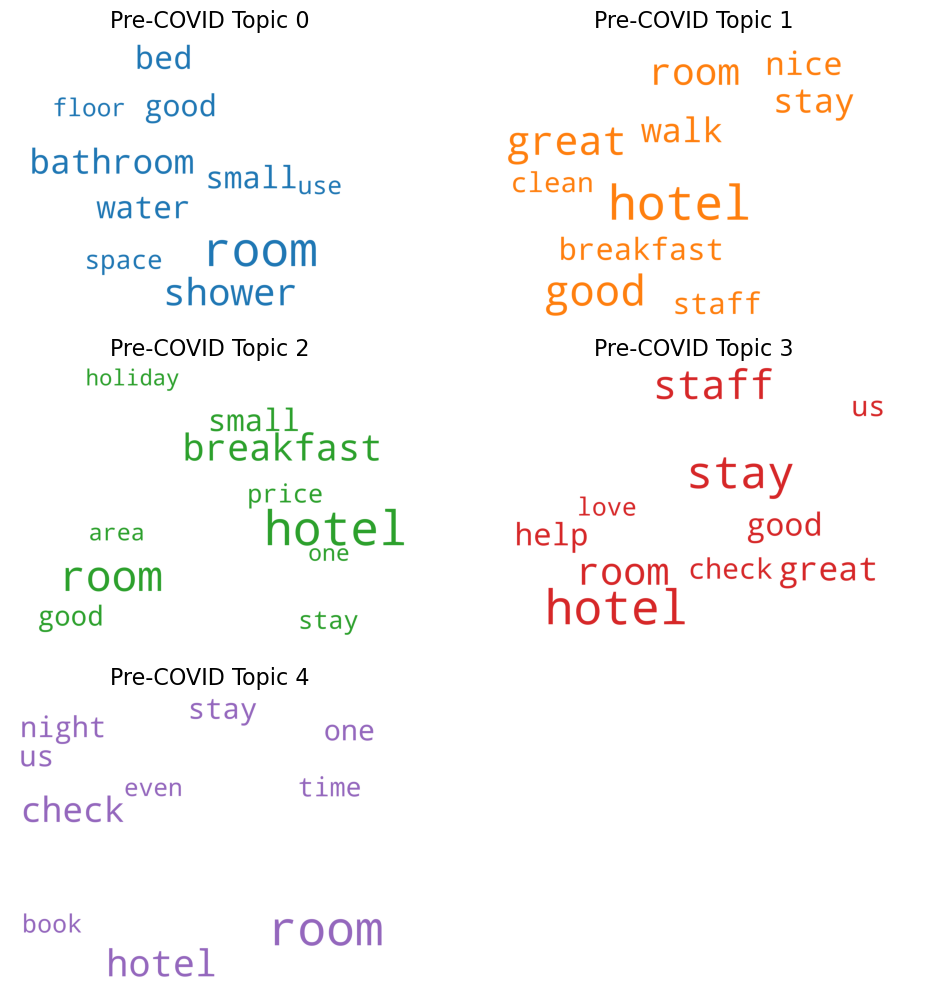

In [12]:
from wordcloud import WordCloud
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

# Create WordClouds for each topic in the pre-COVID dataset
clouds_pre = []

for i in range(5):
    cloud = WordCloud(background_color='white',
                      width=2500,
                      height=1800,
                      max_words=10,
                      colormap='tab10',
                      color_func=lambda *args, **kwargs: cols[i],
                      prefer_horizontal=1.0)
    topic_words = dict(ldamodel.show_topic(i, topn=10))
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    clouds_pre.append(cloud)

# Plot the WordClouds for pre-COVID topics
fig_pre, axes_pre = plt.subplots(3, 2, figsize=(10, 10), sharex=True, sharey=True)

for i, ax in enumerate(axes_pre.flatten()):
    fig_pre.add_subplot(ax)
    if i < len(clouds_pre):
        plt.gca().imshow(clouds_pre[i])
        plt.gca().set_title('Pre-COVID Topic ' + str(i), fontdict=dict(size=16))
        plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [13]:
vis = pyLDAvis.gensim.prepare(topic_model=ldamodel, corpus=pre_corpus, dictionary=pre_dict)
pyLDAvis.enable_notebook()
pyLDAvis.display(vis)

## Bigrams

In [56]:
clean_data = df_filtered['stem_review'].apply(preprocess)
clean_data = clean_data.apply(lambda x: ' '.join(x))

In [57]:
from nltk import ngrams
bigrams_data = []

for d in clean_data:
    tokens = word_tokenize(d)
    bigrams_data.append(["_".join(w) for w in ngrams(tokens, 2)])


In [58]:
##Generate LDA dictionary and corpus
pre_dict = corpora.Dictionary(bigrams_data)
pre_corpus = [pre_dict.doc2bow(text) for text in bigrams_data]

lda = gensim.models.ldamodel.LdaModel
pre_ldamodel = lda(pre_corpus, num_topics=5, id2word=pre_dict, passes=15)

In [59]:
# For Pre-COVID
topics_pre_stembi = pre_ldamodel.show_topics(formatted=False)
data_flat_pre = [word for word_list in bigrams_data for word in word_list]

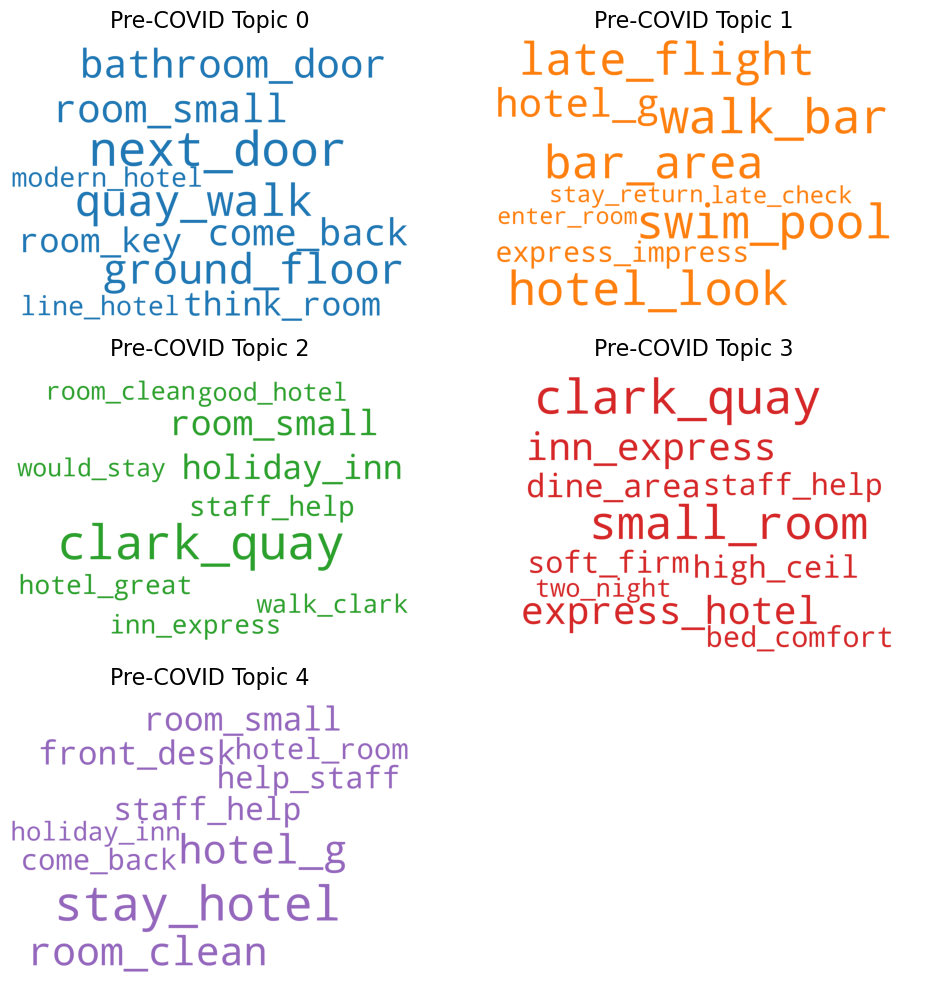

In [60]:
from wordcloud import WordCloud
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

# Create WordClouds for each topic in the pre-COVID dataset
clouds_pre = []

for i in range(5):
    cloud = WordCloud(background_color='white',
                      width=2500,
                      height=1800,
                      max_words=10,
                      colormap='tab10',
                      color_func=lambda *args, **kwargs: cols[i],
                      prefer_horizontal=1.0)
    topic_words = dict(pre_ldamodel.show_topic(i, topn=10))
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    clouds_pre.append(cloud)

# Plot the WordClouds for pre-COVID topics
fig_pre, axes_pre = plt.subplots(3, 2, figsize=(10, 10), sharex=True, sharey=True)

for i, ax in enumerate(axes_pre.flatten()):
    fig_pre.add_subplot(ax)
    if i < len(clouds_pre):
        plt.gca().imshow(clouds_pre[i])
        plt.gca().set_title('Pre-COVID Topic ' + str(i), fontdict=dict(size=16))
        plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [61]:
vis = pyLDAvis.gensim.prepare(topic_model=pre_ldamodel, corpus=pre_corpus, dictionary=pre_dict)
pyLDAvis.enable_notebook()
pyLDAvis.display(vis)

## Lemmatized

In [62]:
df_filtered['lem_review'] = df_filtered['lem_review'].apply(remove_stopwords)
df_filtered['lem_review'] = df_filtered['lem_review'].apply(remove_non_english_words, valid_words=english_words)
df_filtered['lem_tokens'] = df_filtered['lem_review'].apply(preprocess)

In [63]:
##Generate LDA dictionary and corpus
pre_dict = corpora.Dictionary(df_filtered['lem_tokens'])
pre_corpus = [pre_dict.doc2bow(text) for text in df_filtered['lem_tokens']]

In [64]:
## find best_coherence:
for i in range(2, 7):
    lda = gensim.models.ldamodel.LdaModel
    pre_ldamodel = lda(pre_corpus, num_topics=i, id2word=pre_dict, passes=15)
    
    precovid_coherence = CoherenceModel(model=pre_ldamodel, texts=df_filtered['lem_tokens'], dictionary=pre_dict, coherence='c_v')
    lda_coherence = precovid_coherence.get_coherence()
    print(f"The coherence score at topic {i} is {lda_coherence}")

The coherence score at topic 2 is 0.37901132660635456
The coherence score at topic 3 is 0.39874886224885236
The coherence score at topic 4 is 0.39508632740739436
The coherence score at topic 5 is 0.37479238963675254
The coherence score at topic 6 is 0.39786571593180237


In [66]:
## Use 5 topics as baseline
lda = gensim.models.ldamodel.LdaModel
pre_ldamodel = lda(pre_corpus, num_topics=3, id2word=pre_dict, passes=15)

In [67]:
# For All
topics_pre_lem = pre_ldamodel.show_topics(formatted=False)
data_flat_pre = [word for word_list in df_filtered['lem_tokens'] for word in word_list]

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_15000\478201950.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df_plot.loc[df_plot.topic_id == i, 'word'], rotation=30, horizontalalignment='right')


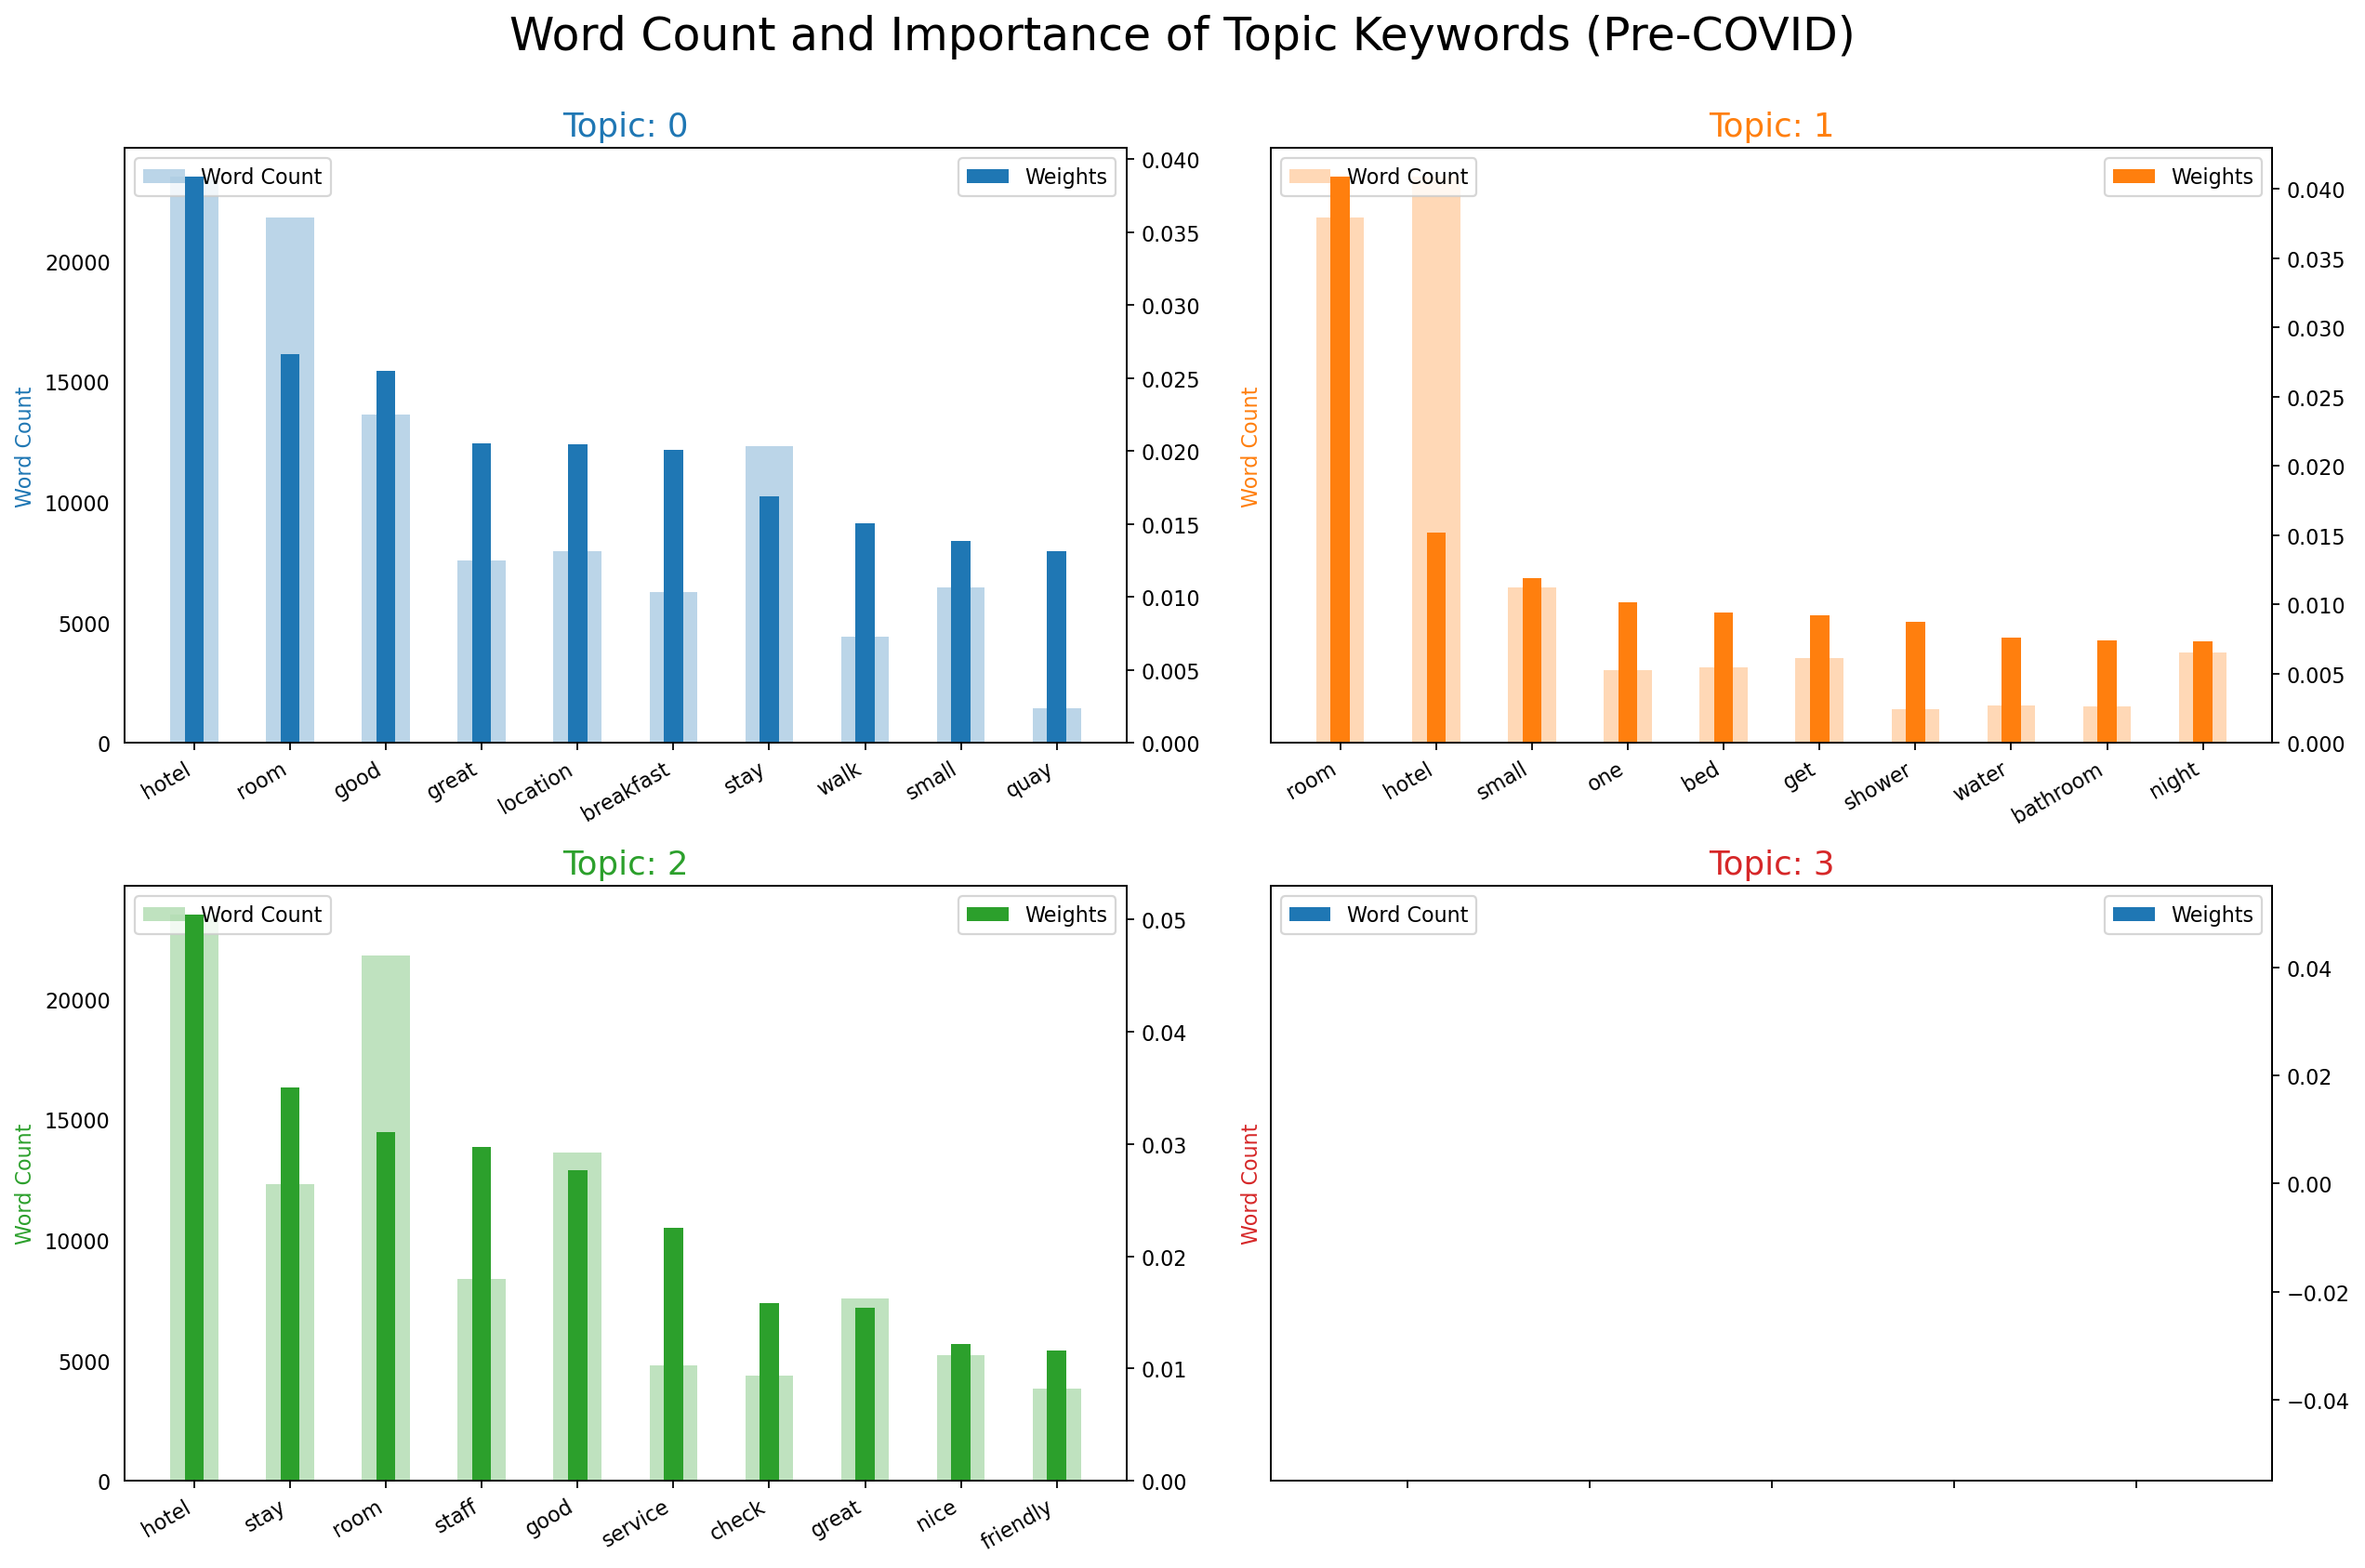

In [69]:
# Create a function to generate the plot
def plot_word_count_importance(topics, data_flat, title):
    out = []
    for i, topic in topics:
        for word, weight in topic:
            out.append([word, i, weight, data_flat.count(word)])

    df_plot = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])

    # Plot Word Count and Weights of Topic Keywords
    fig, axes = plt.subplots(2, 2, figsize=(16, 10), sharey=True, dpi=160)
    cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    for i, ax in enumerate(axes.flatten()):
        ax.bar(x='word', height='word_count', data=df_plot.loc[df_plot.topic_id == i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
        ax_twin = ax.twinx()
        ax_twin.bar(x='word', height='importance', data=df_plot.loc[df_plot.topic_id == i, :], color=cols[i], width=0.2, label='Weights')
        ax.set_ylabel('Word Count', color=cols[i])
        ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
        ax.tick_params(axis='y', left=False)
        ax.set_xticklabels(df_plot.loc[df_plot.topic_id == i, 'word'], rotation=30, horizontalalignment='right')
        ax.legend(loc='upper left')
        ax_twin.legend(loc='upper right')

    fig.tight_layout(w_pad=2)
    fig.suptitle(title, fontsize=22, y=1.05)
    plt.show()

# For Pre-COVID
plot_word_count_importance(topics_pre_lem, data_flat_pre, 'Word Count and Importance of Topic Keywords (Pre-COVID)')

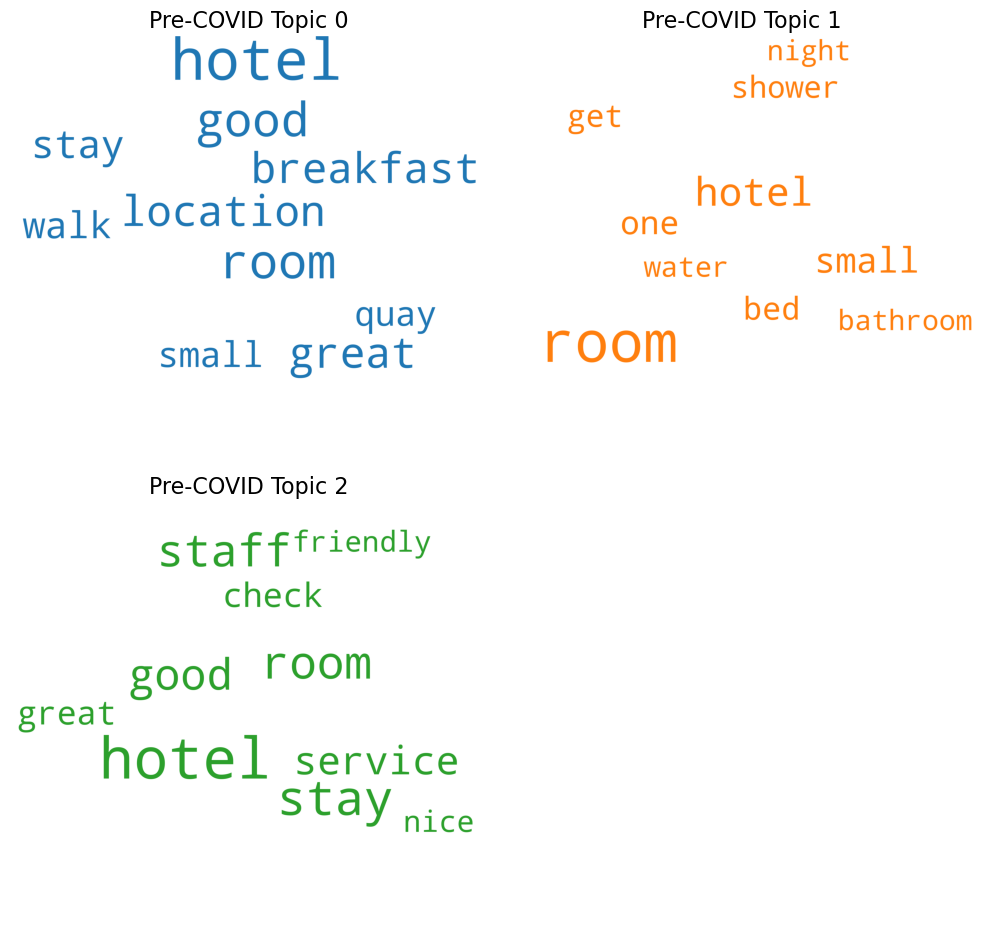

In [70]:
from wordcloud import WordCloud
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

# Create WordClouds for each topic in the pre-COVID dataset
clouds_pre = []

for i in range(3):
    cloud = WordCloud(background_color='white',
                      width=2500,
                      height=1800,
                      max_words=10,
                      colormap='tab10',
                      color_func=lambda *args, **kwargs: cols[i],
                      prefer_horizontal=1.0)
    topic_words = dict(pre_ldamodel.show_topic(i, topn=10))
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    clouds_pre.append(cloud)

# Plot the WordClouds for pre-COVID topics
fig_pre, axes_pre = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)

for i, ax in enumerate(axes_pre.flatten()):
    fig_pre.add_subplot(ax)
    if i < len(clouds_pre):
        plt.gca().imshow(clouds_pre[i])
        plt.gca().set_title('Pre-COVID Topic ' + str(i), fontdict=dict(size=16))
        plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [71]:
vis = pyLDAvis.gensim.prepare(topic_model=pre_ldamodel, corpus=pre_corpus, dictionary=pre_dict)
pyLDAvis.enable_notebook()
pyLDAvis.display(vis)

## Bigrams

In [72]:
clean_data = df_filtered['lem_review'].apply(preprocess)
clean_data = clean_data.apply(lambda x: ' '.join(x))

In [73]:
from nltk import ngrams
bigrams_data = []

for d in clean_data:
    tokens = word_tokenize(d)
    bigrams_data.append(["_".join(w) for w in ngrams(tokens, 2)])


In [76]:
##Generate LDA dictionary and corpus
pre_dict = corpora.Dictionary(bigrams_data)
pre_corpus = [pre_dict.doc2bow(text) for text in bigrams_data]

lda = gensim.models.ldamodel.LdaModel
pre_ldamodel = lda(pre_corpus, num_topics=3, id2word=pre_dict, passes=15)

In [77]:
# For Pre-COVID
topics_pre_lembi = pre_ldamodel.show_topics(formatted=False)
data_flat_pre = [word for word_list in bigrams_data for word in word_list]

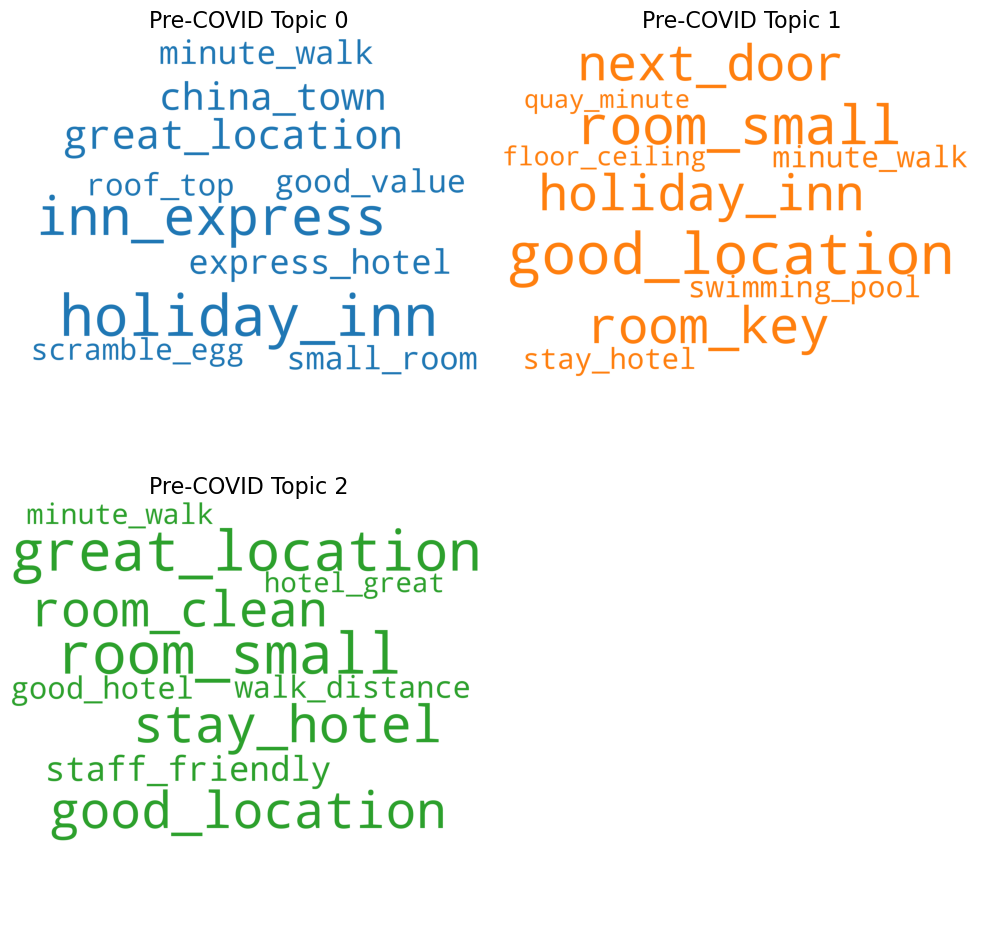

In [78]:
from wordcloud import WordCloud
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

# Create WordClouds for each topic in the pre-COVID dataset
clouds_pre = []

for i in range(3):
    cloud = WordCloud(background_color='white',
                      width=2500,
                      height=1800,
                      max_words=10,
                      colormap='tab10',
                      color_func=lambda *args, **kwargs: cols[i],
                      prefer_horizontal=1.0)
    topic_words = dict(pre_ldamodel.show_topic(i, topn=10))
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    clouds_pre.append(cloud)

# Plot the WordClouds for pre-COVID topics
fig_pre, axes_pre = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)

for i, ax in enumerate(axes_pre.flatten()):
    fig_pre.add_subplot(ax)
    if i < len(clouds_pre):
        plt.gca().imshow(clouds_pre[i])
        plt.gca().set_title('Pre-COVID Topic ' + str(i), fontdict=dict(size=16))
        plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [79]:
vis = pyLDAvis.gensim.prepare(topic_model=pre_ldamodel, corpus=pre_corpus, dictionary=pre_dict)
pyLDAvis.enable_notebook()
pyLDAvis.display(vis)

## Topic Extraction

In [35]:
topics_pre_stem

[(0,
  [('room', 0.04426023),
   ('shower', 0.025041107),
   ('bathroom', 0.020877376),
   ('bed', 0.01776482),
   ('water', 0.017396603),
   ('small', 0.016952863),
   ('good', 0.016093481),
   ('space', 0.01171376),
   ('use', 0.010560547),
   ('floor', 0.010458657),
   ('pool', 0.01002204),
   ('area', 0.009081878),
   ('well', 0.00866329),
   ('also', 0.008598057),
   ('one', 0.008192735),
   ('light', 0.00818527),
   ('hot', 0.007892164),
   ('need', 0.00730924),
   ('hotel', 0.0068845986),
   ('night', 0.0068732267)]),
 (1,
  [('hotel', 0.059125893),
   ('good', 0.04547817),
   ('great', 0.040966015),
   ('room', 0.036037315),
   ('stay', 0.02869365),
   ('walk', 0.028679434),
   ('nice', 0.025762819),
   ('breakfast', 0.0230072),
   ('staff', 0.021719193),
   ('clean', 0.018696075),
   ('pool', 0.018047048),
   ('small', 0.015842905),
   ('station', 0.0138248615),
   ('well', 0.012731784),
   ('close', 0.012527352),
   ('comfort', 0.012258677),
   ('place', 0.012058192),
   ('re

In [36]:
top_dict = {}
for i in topics_pre_stem:
    top_dict[i[0]] = []
    for j in i[1]:
        top_dict[i[0]].append(j[0])

In [37]:
top_dict

{0: ['room',
  'shower',
  'bathroom',
  'bed',
  'water',
  'small',
  'good',
  'space',
  'use',
  'floor',
  'pool',
  'area',
  'well',
  'also',
  'one',
  'light',
  'hot',
  'need',
  'hotel',
  'night'],
 1: ['hotel',
  'good',
  'great',
  'room',
  'stay',
  'walk',
  'nice',
  'breakfast',
  'staff',
  'clean',
  'pool',
  'small',
  'station',
  'well',
  'close',
  'comfort',
  'place',
  'restaur',
  'food',
  'help'],
 2: ['hotel',
  'room',
  'breakfast',
  'small',
  'good',
  'price',
  'stay',
  'area',
  'one',
  'holiday',
  'day',
  'clean',
  'expect',
  'night',
  'new',
  'well',
  'roof',
  'bar',
  'like',
  'walk'],
 3: ['hotel',
  'stay',
  'staff',
  'room',
  'great',
  'good',
  'help',
  'us',
  'check',
  'love',
  'clean',
  'thank',
  'nice',
  'comfort',
  'time',
  'excel',
  'would',
  'recommend',
  'come',
  'back'],
 4: ['room',
  'hotel',
  'check',
  'us',
  'stay',
  'night',
  'one',
  'time',
  'book',
  'even',
  'day',
  'staff',
  'get

In [38]:
df_res = pd.DataFrame(top_dict)
df_res

0          1          2          3      4
0       room      hotel      hotel      hotel   room
1     shower       good       room       stay  hotel
2   bathroom      great  breakfast      staff  check
3        bed       room      small       room     us
4      water       stay       good      great   stay
5      small       walk      price       good  night
6       good       nice       stay       help    one
7      space  breakfast       area         us   time
8        use      staff        one      check   book
9      floor      clean    holiday       love   even
10      pool       pool        day      clean    day
11      area      small      clean      thank  staff
12      well    station     expect       nice    get
13      also       well      night    comfort   look
14       one      close        new       time  could
15     light    comfort       well      excel    ask
16       hot      place       roof      would   roof
17      need    restaur        bar  recommend   late
18     hotel       food       like       come  would
19     night       help       walk       back   last

In [36]:
df_res.to_csv('3-star LDA.csv')

## DP

In [19]:
import spacy
nlp = spacy.load("en_core_web_sm")

In [20]:
# Pass in LDA topics output to remove overlap words by choosing highest prob
def restruct_topics(topics): 
    word_prob_dict = {}
    for i in range(len(topics)):
        topic_num = topics[i][0]
        for word, prob in topics[i][1]:
            if word in word_prob_dict:
                word_prob_dict[word].append((topic_num, prob))
            else:
                ls = [(topic_num, prob)]
                word_prob_dict[word] = ls
    new_dict = {}
    for word in word_prob_dict:
        topic, highest_prob = max(word_prob_dict[word], key = lambda x: x[1])
        if topic in new_dict:
            new_dict[topic].append(word)
        else:
            ls = [word]
            new_dict[topic] = ls
    return new_dict

In [21]:
new_dict = restruct_topics(topics_pre_stem)

In [22]:
new_dict = restruct_topics(topics_pre_stem)
for x in new_dict:
    print(f'length topic {x}: {len(new_dict[x])}')

length topic 0: 14
length topic 4: 14
length topic 3: 12
length topic 2: 13
length topic 1: 9


In [23]:
#takes in the dataframe and appends to each row (aspect, review) pair(s)
def dep_parse(data, new_dict):
    data['aspect_sentiment'] = np.empty((len(data), 0)).tolist()
    for i in range(len(data)):
        sentence = data['combined_review'][i]
        doc = nlp(sentence)
        aspect_sentiment = []
        for word in doc:
            cond = False
            for x in new_dict.values():
                if word.text in x:
                    cond = True
                    break
            if not cond:
                continue
            if word.pos_ == 'NOUN': 
                for j in word.lefts:
                    #print(j, word, j.dep_, j.pos_)
                    if j.dep_ == 'amod' and j.pos_ == 'ADJ':
                        tup = [word, j, list(new_dict.values()).index(x)]
                        #print(tup)
                        aspect_sentiment.append(tup)
                    for k in j.lefts:
                        if k.dep_ == 'advmod':
                            #print(word, j ,k)
                            tup = (word, k.text + ' ' + j.text)
                            aspect_sentiment.append(tup)
                            if (word, j) in aspect_sentiment:
                                aspect_sentiment.remove([word, j, list(new_dict.values()).index(x)])
        data['aspect_sentiment'][i] = aspect_sentiment

In [24]:
df_filtered = df_filtered.reset_index()

In [25]:
dep_parse(df_filtered, new_dict)

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

In [26]:
df_filtered['aspect_sentiment']

0        [[hotel, decent, 0], [room, compact, 2], [bath...
1        [[hotel, Good, 0], [place, great, 0], [hotel, ...
2                     [[place, Good, 0], [place, Good, 0]]
3        [[staff, great, 0], [hotel, neat, 0], [door, n...
4                       [[door, next, 4], [time, long, 0]]
                               ...                        
14065                                                   []
14066                                                   []
14067                [[hotel, Good, 0], [room, actual, 2]]
14068                                [[room, adjacent, 2]]
14069                                    [[time, next, 0]]
Name: aspect_sentiment, Length: 14070, dtype: object

## Import PyABSA

In [14]:
df_json_pre = pd.read_json('../pyABSA_outputs/precovid_3star.json')
df_json_post = pd.read_json('../pyABSA_outputs/postcovid_3star.json')

In [15]:
df_json_pre = df_json_pre[['sentence', 'tokens', 'aspect', 'sentiment', 'confidence']]
df_json_pre.head()

sentence  \
0  cozy hotel spend night hotel service provide h...   
1  smart clean good location value money second s...   
2  wonderful experience first time hotel last fri...   
3  great base tourist firstly good point comforta...   
4  good location comfortable hotel nice staff tot...   

                                              tokens  \
0  [cozy, hotel, spend, night, hotel, service, pr...   
1  [smart, clean, good, location, value, money, s...   
2  [wonderful, experience, first, time, hotel, la...   
3  [great, base, tourist, firstly, good, point, c...   
4  [good, location, comfortable, hotel, nice, sta...   

                                              aspect  \
0                         [service, breakfast taste]   
1                [location, welcome drink breakfast]   
2                              [food, coffee, water]   
3  [room, receptionist, breakfast buffet style, p...   
4                       [location, staff, room, gym]   

                                           sentiment  \
0                               [Positive, Negative]   
1                               [Positive, Positive]   
2                      [Positive, Positive, Neutral]   
3  [Positive, Positive, Positive, Positive, Posit...   
4           [Positive, Positive, Positive, Positive]   

                                          confidence  
0                       [0.9981000000000001, 0.9897]  
1                       [0.9934000000000001, 0.9668]  
2   [0.6879000000000001, 0.9976, 0.8190000000000001]  
3  [0.9983000000000001, 0.9984000000000001, 0.999...  
4  [0.9984000000000001, 0.9952000000000001, 0.999...

In [16]:
df_json_post = df_json_post[['sentence', 'tokens', 'aspect', 'sentiment', 'confidence']]
df_json_post.head()

sentence  \
0  cozy hotel spend night hotel service provide h...   
1  smart clean good location value money second s...   
2  wonderful experience first time hotel last fri...   
3  great base tourist firstly good point comforta...   
4  good location comfortable hotel nice staff tot...   

                                              tokens  \
0  [cozy, hotel, spend, night, hotel, service, pr...   
1  [smart, clean, good, location, value, money, s...   
2  [wonderful, experience, first, time, hotel, la...   
3  [great, base, tourist, firstly, good, point, c...   
4  [good, location, comfortable, hotel, nice, sta...   

                                              aspect  \
0                         [service, breakfast taste]   
1                [location, welcome drink breakfast]   
2                              [food, coffee, water]   
3  [room, receptionist, breakfast buffet style, p...   
4                       [location, staff, room, gym]   

                                           sentiment  \
0                               [Positive, Negative]   
1                               [Positive, Positive]   
2                      [Positive, Positive, Neutral]   
3  [Positive, Positive, Positive, Positive, Posit...   
4           [Positive, Positive, Positive, Positive]   

                                          confidence  
0                       [0.9981000000000001, 0.9897]  
1                       [0.9934000000000001, 0.9668]  
2   [0.6879000000000001, 0.9976, 0.8190000000000001]  
3  [0.9983000000000001, 0.9984000000000001, 0.999...  
4  [0.9984000000000001, 0.9952000000000001, 0.999...

In [17]:
df_json = pd.concat([df_json_pre, df_json_post], ignore_index=True)

In [18]:
df_json

sentence  \
0      cozy hotel spend night hotel service provide h...   
1      smart clean good location value money second s...   
2      wonderful experience first time hotel last fri...   
3      great base tourist firstly good point comforta...   
4      good location comfortable hotel nice staff tot...   
...                                                  ...   
24357  small enough stay location excellet close mrt ...   
24358  great experience visit singapore recently fami...   
24359  good hotel great location husband stay night s...   
24360  stay hotel staff friendly efficient room adequ...   
24361  great hotel awesome location pleasure stay cut...   

                                                  tokens  \
0      [cozy, hotel, spend, night, hotel, service, pr...   
1      [smart, clean, good, location, value, money, s...   
2      [wonderful, experience, first, time, hotel, la...   
3      [great, base, tourist, firstly, good, point, c...   
4      [good, location, comfortable, hotel, nice, sta...   
...                                                  ...   
24357  [small, enough, stay, location, excellet, clos...   
24358  [great, experience, visit, singapore, recently...   
24359  [good, hotel, great, location, husband, stay, ...   
24360  [stay, hotel, staff, friendly, efficient, room...   
24361  [great, hotel, awesome, location, pleasure, st...   

                                                  aspect  \
0                             [service, breakfast taste]   
1                    [location, welcome drink breakfast]   
2                                  [food, coffee, water]   
3      [room, receptionist, breakfast buffet style, p...   
4                           [location, staff, room, gym]   
...                                                  ...   
24357                          [location, swimming pool]   
24358  [service, lobby staff, light, wifi amenity, br...   
24359      [bed pillow, rooftop pool, view, staff, wait]   
24360          [staff, room, location, snack, bar, food]   
24361             [location, area, breakfast, selection]   

                                               sentiment  \
0                                   [Positive, Negative]   
1                                   [Positive, Positive]   
2                          [Positive, Positive, Neutral]   
3      [Positive, Positive, Positive, Positive, Posit...   
4               [Positive, Positive, Positive, Positive]   
...                                                  ...   
24357                               [Negative, Negative]   
24358  [Positive, Positive, Positive, Positive, Posit...   
24359  [Positive, Positive, Positive, Negative, Negat...   
24360  [Positive, Positive, Positive, Negative, Neutr...   
24361           [Positive, Positive, Positive, Positive]   

                                              confidence  
0                           [0.9981000000000001, 0.9897]  
1                           [0.9934000000000001, 0.9668]  
2       [0.6879000000000001, 0.9976, 0.8190000000000001]  
3      [0.9983000000000001, 0.9984000000000001, 0.999...  
4      [0.9984000000000001, 0.9952000000000001, 0.999...  
...                                                  ...  
24357                       [0.9922000000000001, 0.9988]  
24358  [0.9602, 0.9987, 0.9967, 0.9974000000000001, 0...  
24359  [0.9991000000000001, 0.9975, 0.7065, 0.9635, 0...  
24360  [0.9823000000000001, 0.9477000000000001, 0.791...  
24361       [0.9971000000000001, 0.8617, 0.7813, 0.9785]  

[24362 rows x 5 columns]

## LDA own model

In [19]:
df_json['docbow'] = df_json['aspect'].apply(lambda x: pre_dict.doc2bow(x))
df_json.head()

sentence  \
0  cozy hotel spend night hotel service provide h...   
1  smart clean good location value money second s...   
2  wonderful experience first time hotel last fri...   
3  great base tourist firstly good point comforta...   
4  good location comfortable hotel nice staff tot...   

                                              tokens  \
0  [cozy, hotel, spend, night, hotel, service, pr...   
1  [smart, clean, good, location, value, money, s...   
2  [wonderful, experience, first, time, hotel, la...   
3  [great, base, tourist, firstly, good, point, c...   
4  [good, location, comfortable, hotel, nice, sta...   

                                              aspect  \
0                         [service, breakfast taste]   
1                [location, welcome drink breakfast]   
2                              [food, coffee, water]   
3  [room, receptionist, breakfast buffet style, p...   
4                       [location, staff, room, gym]   

                                           sentiment  \
0                               [Positive, Negative]   
1                               [Positive, Positive]   
2                      [Positive, Positive, Neutral]   
3  [Positive, Positive, Positive, Positive, Posit...   
4           [Positive, Positive, Positive, Positive]   

                                          confidence  \
0                       [0.9981000000000001, 0.9897]   
1                       [0.9934000000000001, 0.9668]   
2   [0.6879000000000001, 0.9976, 0.8190000000000001]   
3  [0.9983000000000001, 0.9984000000000001, 0.999...   
4  [0.9984000000000001, 0.9952000000000001, 0.999...   

                                  docbow  
0                                     []  
1                                     []  
2                    [(15, 1), (528, 1)]  
3  [(35, 1), (56, 1), (83, 1), (225, 1)]  
4           [(35, 1), (83, 1), (723, 1)]

## Topic with threshold

In [20]:
df_json['topics'] = np.nan
df_json.head()

sentence  \
0  cozy hotel spend night hotel service provide h...   
1  smart clean good location value money second s...   
2  wonderful experience first time hotel last fri...   
3  great base tourist firstly good point comforta...   
4  good location comfortable hotel nice staff tot...   

                                              tokens  \
0  [cozy, hotel, spend, night, hotel, service, pr...   
1  [smart, clean, good, location, value, money, s...   
2  [wonderful, experience, first, time, hotel, la...   
3  [great, base, tourist, firstly, good, point, c...   
4  [good, location, comfortable, hotel, nice, sta...   

                                              aspect  \
0                         [service, breakfast taste]   
1                [location, welcome drink breakfast]   
2                              [food, coffee, water]   
3  [room, receptionist, breakfast buffet style, p...   
4                       [location, staff, room, gym]   

                                           sentiment  \
0                               [Positive, Negative]   
1                               [Positive, Positive]   
2                      [Positive, Positive, Neutral]   
3  [Positive, Positive, Positive, Positive, Posit...   
4           [Positive, Positive, Positive, Positive]   

                                          confidence  \
0                       [0.9981000000000001, 0.9897]   
1                       [0.9934000000000001, 0.9668]   
2   [0.6879000000000001, 0.9976, 0.8190000000000001]   
3  [0.9983000000000001, 0.9984000000000001, 0.999...   
4  [0.9984000000000001, 0.9952000000000001, 0.999...   

                                  docbow  topics  
0                                     []     NaN  
1                                     []     NaN  
2                    [(15, 1), (528, 1)]     NaN  
3  [(35, 1), (56, 1), (83, 1), (225, 1)]     NaN  
4           [(35, 1), (83, 1), (723, 1)]     NaN

In [21]:
df_json['topics'] = df_json['docbow'].apply(lambda x: ldamodel.get_document_topics(x))

In [22]:
df_json.head()

sentence  \
0  cozy hotel spend night hotel service provide h...   
1  smart clean good location value money second s...   
2  wonderful experience first time hotel last fri...   
3  great base tourist firstly good point comforta...   
4  good location comfortable hotel nice staff tot...   

                                              tokens  \
0  [cozy, hotel, spend, night, hotel, service, pr...   
1  [smart, clean, good, location, value, money, s...   
2  [wonderful, experience, first, time, hotel, la...   
3  [great, base, tourist, firstly, good, point, c...   
4  [good, location, comfortable, hotel, nice, sta...   

                                              aspect  \
0                         [service, breakfast taste]   
1                [location, welcome drink breakfast]   
2                              [food, coffee, water]   
3  [room, receptionist, breakfast buffet style, p...   
4                       [location, staff, room, gym]   

                                           sentiment  \
0                               [Positive, Negative]   
1                               [Positive, Positive]   
2                      [Positive, Positive, Neutral]   
3  [Positive, Positive, Positive, Positive, Posit...   
4           [Positive, Positive, Positive, Positive]   

                                          confidence  \
0                       [0.9981000000000001, 0.9897]   
1                       [0.9934000000000001, 0.9668]   
2   [0.6879000000000001, 0.9976, 0.8190000000000001]   
3  [0.9983000000000001, 0.9984000000000001, 0.999...   
4  [0.9984000000000001, 0.9952000000000001, 0.999...   

                                  docbow  \
0                                     []   
1                                     []   
2                    [(15, 1), (528, 1)]   
3  [(35, 1), (56, 1), (83, 1), (225, 1)]   
4           [(35, 1), (83, 1), (723, 1)]   

                                              topics  
0  [(0, 0.2), (1, 0.2), (2, 0.2), (3, 0.2), (4, 0...  
1  [(0, 0.2), (1, 0.2), (2, 0.2), (3, 0.2), (4, 0...  
2  [(0, 0.72353435), (1, 0.073161796), (2, 0.0684...  
3  [(0, 0.04032781), (1, 0.040969674), (2, 0.0405...  
4  [(0, 0.051401157), (1, 0.7950646), (2, 0.05097...

In [23]:
df_json['cleaned_topics'] = df_json['topics'].apply(lambda x: [x[0] for x in x if x[1] > 0.20000001] )

In [24]:
print(f"The number of reviews without any topics is {sum(df_json['cleaned_topics'].apply(lambda x: len(x) == 0))}")
print(f"The number of reviews with exactly one topic is {sum(df_json['cleaned_topics'].apply(lambda x: len(x) == 1))}")
print(f"The number of reviews with more than one topic is {sum(df_json['cleaned_topics'].apply(lambda x: len(x) > 1))}")

The number of reviews without any topics is 3976
The number of reviews with exactly one topic is 16760
The number of reviews with more than one topic is 3626


## Cosine Similarity on Missing Data

In [25]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
import scipy.sparse

In [26]:
df_filtered['vec_tokens'] = df_filtered['stem_tokens'].apply(lambda x: ' '.join(x))

In [27]:
df_filtered['stem_tokens']

0       [clean, comfort, hotel, room, find, decent, ho...
1       [good, hotel, great, great, place, great, room...
2       [good, place, decent, price, good, place, good...
3       [great, great, staff, neat, hotel, line, star,...
4       [good, budget, stay, stay, day, nice, seven, e...
                              ...                        
2164    [small, enough, stay, close, station, swim, po...
2165    [great, visit, recent, short, day, night, must...
2166    [good, hotel, great, husband, stay, night, hal...
2167    [stay, hotel, staff, room, passageway, room, b...
2168    [great, hotel, stay, cut, hotel, night, cool, ...
Name: stem_tokens, Length: 14070, dtype: object

In [28]:
vectorizer = CountVectorizer()
transformer = TfidfTransformer()

filtered_vec = vectorizer.fit_transform(df_filtered['vec_tokens'])
filtered_trf = transformer.fit_transform(filtered_vec)

In [29]:
missing_data = df_json[df_json['docbow'].apply(lambda x: len(x) == 0)]

In [30]:
missing_data.head()

sentence  \
0   cozy hotel spend night hotel service provide h...   
1   smart clean good location value money second s...   
12  convenient stay singapore accommodation cheap ...   
15  poot service regular client accor hotel around...   
17  less excitement less excitement compare first ...   

                                               tokens  \
0   [cozy, hotel, spend, night, hotel, service, pr...   
1   [smart, clean, good, location, value, money, s...   
12  [convenient, stay, singapore, accommodation, c...   
15  [poot, service, regular, client, accor, hotel,...   
17  [less, excitement, less, excitement, compare, ...   

                                 aspect                       sentiment  \
0            [service, breakfast taste]            [Positive, Negative]   
1   [location, welcome drink breakfast]            [Positive, Positive]   
12  [welcome drink, wifi, housekeeping]  [Positive, Positive, Positive]   
15               [housekeeping service]                      [Negative]   
17            [room rate, dining table]            [Negative, Negative]   

                                          confidence docbow  \
0                       [0.9981000000000001, 0.9897]     []   
1                       [0.9934000000000001, 0.9668]     []   
12  [0.9893000000000001, 0.9925, 0.9205000000000001]     []   
15                                          [0.9987]     []   
17                                  [0.8494, 0.9978]     []   

                                               topics cleaned_topics  
0   [(0, 0.2), (1, 0.2), (2, 0.2), (3, 0.2), (4, 0...             []  
1   [(0, 0.2), (1, 0.2), (2, 0.2), (3, 0.2), (4, 0...             []  
12  [(0, 0.2), (1, 0.2), (2, 0.2), (3, 0.2), (4, 0...             []  
15  [(0, 0.2), (1, 0.2), (2, 0.2), (3, 0.2), (4, 0...             []  
17  [(0, 0.2), (1, 0.2), (2, 0.2), (3, 0.2), (4, 0...             []

In [31]:
aspect_vec = vectorizer.transform(missing_data['aspect'].apply(lambda x: ' '.join(x)))
aspect_trf = transformer.transform(aspect_vec)

In [39]:
cos_res = {}
for i in range(5):
    topic_words_vec = vectorizer.transform(list(df_res[i]))
    topic_words_trf = transformer.transform(topic_words_vec)
    r = cosine_similarity(aspect_trf, topic_words_trf)
    cos_sim = np.rad2deg(np.arccos(r))
    
    mid_res = []
    for j in cos_sim:
        min_cos_sim = min(j)
        mid_res.append(min_cos_sim)
    cos_res[i] = mid_res

In [40]:
sentences_used = set()
for i in cos_res:
    print(f"Sentences for topic {i}:")
    for j in range(len(cos_res[i])):
        if cos_res[i][j] < 75:
            print(f"Sentence: {missing_data.index[j]}")
            sentences_used.add(missing_data.index[j])
            missing_data.loc[missing_data.index[j], 'cleaned_topics'].append(i)
            

Sentences for topic 0:
Sentence: 17
Sentence: 31
Sentence: 51
Sentence: 52
Sentence: 70
Sentence: 101
Sentence: 144
Sentence: 159
Sentence: 165
Sentence: 173
Sentence: 287
Sentence: 300
Sentence: 337
Sentence: 394
Sentence: 416
Sentence: 468
Sentence: 494
Sentence: 552
Sentence: 567
Sentence: 569
Sentence: 637
Sentence: 656
Sentence: 672
Sentence: 675
Sentence: 685
Sentence: 687
Sentence: 709
Sentence: 717
Sentence: 735
Sentence: 782
Sentence: 798
Sentence: 806
Sentence: 854
Sentence: 865
Sentence: 889
Sentence: 918
Sentence: 922
Sentence: 957
Sentence: 961
Sentence: 998
Sentence: 1079
Sentence: 1084
Sentence: 1090
Sentence: 1249
Sentence: 1253
Sentence: 1311
Sentence: 1313
Sentence: 1314
Sentence: 1369
Sentence: 1372
Sentence: 1404
Sentence: 1450
Sentence: 1461
Sentence: 1464
Sentence: 1524
Sentence: 1562
Sentence: 1579
Sentence: 1589
Sentence: 1727
Sentence: 1816
Sentence: 1821
Sentence: 1837
Sentence: 1877
Sentence: 1888
Sentence: 1893
Sentence: 1899
Sentence: 1913
Sentence: 1919
Se

In [41]:
total_unused = 0
for i in range(len(missing_data)):
    if missing_data.index[i] not in sentences_used:
        total_unused += 1

print(total_unused)

2014


In [42]:
missing_data

sentence  \
0      cozy hotel spend night hotel service provide h...   
1      smart clean good location value money second s...   
12     convenient stay singapore accommodation cheap ...   
15     poot service regular client accor hotel around...   
17     less excitement less excitement compare first ...   
...                                                  ...   
24317  lovely hotel good location good welcome recept...   
24341  great express stay two night singapore visit r...   
24349  stinky pillow stay whilst hotel overall fine o...   
24356  beyond expectation mrs currently halfway stay ...   
24357  small enough stay location excellet close mrt ...   

                                                  tokens  \
0      [cozy, hotel, spend, night, hotel, service, pr...   
1      [smart, clean, good, location, value, money, s...   
12     [convenient, stay, singapore, accommodation, c...   
15     [poot, service, regular, client, accor, hotel,...   
17     [less, excitement, less, excitement, compare, ...   
...                                                  ...   
24317  [lovely, hotel, good, location, good, welcome,...   
24341  [great, express, stay, two, night, singapore, ...   
24349  [stinky, pillow, stay, whilst, hotel, overall,...   
24356  [beyond, expectation, mrs, currently, halfway,...   
24357  [small, enough, stay, location, excellet, clos...   

                                                  aspect  \
0                             [service, breakfast taste]   
1                    [location, welcome drink breakfast]   
12                   [welcome drink, wifi, housekeeping]   
15                                [housekeeping service]   
17                             [room rate, dining table]   
...                                                  ...   
24317                                                 []   
24341  [lobby area outside terrace, rooftop pool, value]   
24349                            [housekeeping, waiting]   
24356  [plan layout, architecture, window bathroom, p...   
24357                          [location, swimming pool]   

                                               sentiment  \
0                                   [Positive, Negative]   
1                                   [Positive, Positive]   
12                        [Positive, Positive, Positive]   
15                                            [Negative]   
17                                  [Negative, Negative]   
...                                                  ...   
24317                                                 []   
24341                      [Positive, Neutral, Positive]   
24349                               [Negative, Negative]   
24356  [Positive, Positive, Positive, Positive, Negat...   
24357                               [Negative, Negative]   

                                              confidence docbow  \
0                           [0.9981000000000001, 0.9897]     []   
1                           [0.9934000000000001, 0.9668]     []   
12      [0.9893000000000001, 0.9925, 0.9205000000000001]     []   
15                                              [0.9987]     []   
17                                      [0.8494, 0.9978]     []   
...                                                  ...    ...   
24317                                                 []     []   
24341   [0.9863000000000001, 0.8842000000000001, 0.9919]     []   
24349           [0.9460000000000001, 0.9237000000000001]     []   
24356  [0.9978, 0.9943000000000001, 0.9705, 0.9302, 0...     []   
24357                       [0.9922000000000001, 0.9988]     []   

                                                  topics   cleaned_topics  
0      [(0, 0.2), (1, 0.2), (2, 0.2), (3, 0.2), (4, 0...           [1, 2]  
1      [(0, 0.2), (1, 0.2), (2, 0.2), (3, 0.2), (4, 0...           [1, 2]  
12     [(0, 0.2), (1, 0.2), (2, 0.2), (3, 0.2), (4, 0...               []  
15     [(0, 0.2), (1, 0.2), (2, 0.2), (3, 0.2), (4, 0..

In [43]:
df_json

sentence  \
0      cozy hotel spend night hotel service provide h...   
1      smart clean good location value money second s...   
2      wonderful experience first time hotel last fri...   
3      great base tourist firstly good point comforta...   
4      good location comfortable hotel nice staff tot...   
...                                                  ...   
24357  small enough stay location excellet close mrt ...   
24358  great experience visit singapore recently fami...   
24359  good hotel great location husband stay night s...   
24360  stay hotel staff friendly efficient room adequ...   
24361  great hotel awesome location pleasure stay cut...   

                                                  tokens  \
0      [cozy, hotel, spend, night, hotel, service, pr...   
1      [smart, clean, good, location, value, money, s...   
2      [wonderful, experience, first, time, hotel, la...   
3      [great, base, tourist, firstly, good, point, c...   
4      [good, location, comfortable, hotel, nice, sta...   
...                                                  ...   
24357  [small, enough, stay, location, excellet, clos...   
24358  [great, experience, visit, singapore, recently...   
24359  [good, hotel, great, location, husband, stay, ...   
24360  [stay, hotel, staff, friendly, efficient, room...   
24361  [great, hotel, awesome, location, pleasure, st...   

                                                  aspect  \
0                             [service, breakfast taste]   
1                    [location, welcome drink breakfast]   
2                                  [food, coffee, water]   
3      [room, receptionist, breakfast buffet style, p...   
4                           [location, staff, room, gym]   
...                                                  ...   
24357                          [location, swimming pool]   
24358  [service, lobby staff, light, wifi amenity, br...   
24359      [bed pillow, rooftop pool, view, staff, wait]   
24360          [staff, room, location, snack, bar, food]   
24361             [location, area, breakfast, selection]   

                                               sentiment  \
0                                   [Positive, Negative]   
1                                   [Positive, Positive]   
2                          [Positive, Positive, Neutral]   
3      [Positive, Positive, Positive, Positive, Posit...   
4               [Positive, Positive, Positive, Positive]   
...                                                  ...   
24357                               [Negative, Negative]   
24358  [Positive, Positive, Positive, Positive, Posit...   
24359  [Positive, Positive, Positive, Negative, Negat...   
24360  [Positive, Positive, Positive, Negative, Neutr...   
24361           [Positive, Positive, Positive, Positive]   

                                              confidence  \
0                           [0.9981000000000001, 0.9897]   
1                           [0.9934000000000001, 0.9668]   
2       [0.6879000000000001, 0.9976, 0.8190000000000001]   
3      [0.9983000000000001, 0.9984000000000001, 0.999...   
4      [0.9984000000000001, 0.9952000000000001, 0.999...   
...                                                  ...   
24357                       [0.9922000000000001, 0.9988]   
24358  [0.9602, 0.9987, 0.9967, 0.9974000000000001, 0...   
24359  [0.9991000000000001, 0.9975, 0.7065, 0.9635, 0...   
24360  [0.9823000000000001, 0.9477000000000001, 0.791...   
24361       [0.9971000000000001, 0.8617, 0.7813, 0.9785]   

                                                docbow  \
0                                                   []   
1                                                   []   
2                                  [(15, 1), (528, 1)]   
3                [(35, 1), (56, 1), (83, 1), (225, 1)]   
4                         [(35, 1), (83, 1), (723, 1)]   
...                                                ...   
24357                                

In [44]:
print(f"The number of reviews without any topics is {sum(df_json['cleaned_topics'].apply(lambda x: len(x) == 0))}")
print(f"The number of reviews with exactly one topic is {sum(df_json['cleaned_topics'].apply(lambda x: len(x) == 1))}")
print(f"The number of reviews with more than one topic is {sum(df_json['cleaned_topics'].apply(lambda x: len(x) > 1))}")

The number of reviews without any topics is 2014
The number of reviews with exactly one topic is 17166
The number of reviews with more than one topic is 5182


In [45]:
df_json

sentence  \
0      cozy hotel spend night hotel service provide h...   
1      smart clean good location value money second s...   
2      wonderful experience first time hotel last fri...   
3      great base tourist firstly good point comforta...   
4      good location comfortable hotel nice staff tot...   
...                                                  ...   
24357  small enough stay location excellet close mrt ...   
24358  great experience visit singapore recently fami...   
24359  good hotel great location husband stay night s...   
24360  stay hotel staff friendly efficient room adequ...   
24361  great hotel awesome location pleasure stay cut...   

                                                  tokens  \
0      [cozy, hotel, spend, night, hotel, service, pr...   
1      [smart, clean, good, location, value, money, s...   
2      [wonderful, experience, first, time, hotel, la...   
3      [great, base, tourist, firstly, good, point, c...   
4      [good, location, comfortable, hotel, nice, sta...   
...                                                  ...   
24357  [small, enough, stay, location, excellet, clos...   
24358  [great, experience, visit, singapore, recently...   
24359  [good, hotel, great, location, husband, stay, ...   
24360  [stay, hotel, staff, friendly, efficient, room...   
24361  [great, hotel, awesome, location, pleasure, st...   

                                                  aspect  \
0                             [service, breakfast taste]   
1                    [location, welcome drink breakfast]   
2                                  [food, coffee, water]   
3      [room, receptionist, breakfast buffet style, p...   
4                           [location, staff, room, gym]   
...                                                  ...   
24357                          [location, swimming pool]   
24358  [service, lobby staff, light, wifi amenity, br...   
24359      [bed pillow, rooftop pool, view, staff, wait]   
24360          [staff, room, location, snack, bar, food]   
24361             [location, area, breakfast, selection]   

                                               sentiment  \
0                                   [Positive, Negative]   
1                                   [Positive, Positive]   
2                          [Positive, Positive, Neutral]   
3      [Positive, Positive, Positive, Positive, Posit...   
4               [Positive, Positive, Positive, Positive]   
...                                                  ...   
24357                               [Negative, Negative]   
24358  [Positive, Positive, Positive, Positive, Posit...   
24359  [Positive, Positive, Positive, Negative, Negat...   
24360  [Positive, Positive, Positive, Negative, Neutr...   
24361           [Positive, Positive, Positive, Positive]   

                                              confidence  \
0                           [0.9981000000000001, 0.9897]   
1                           [0.9934000000000001, 0.9668]   
2       [0.6879000000000001, 0.9976, 0.8190000000000001]   
3      [0.9983000000000001, 0.9984000000000001, 0.999...   
4      [0.9984000000000001, 0.9952000000000001, 0.999...   
...                                                  ...   
24357                       [0.9922000000000001, 0.9988]   
24358  [0.9602, 0.9987, 0.9967, 0.9974000000000001, 0...   
24359  [0.9991000000000001, 0.9975, 0.7065, 0.9635, 0...   
24360  [0.9823000000000001, 0.9477000000000001, 0.791...   
24361       [0.9971000000000001, 0.8617, 0.7813, 0.9785]   

                                                docbow  \
0                                                   []   
1                                                   []   
2                                  [(15, 1), (528, 1)]   
3                [(35, 1), (56, 1), (83, 1), (225, 1)]   
4                         [(35, 1), (83, 1), (723, 1)]   
...                                                ...   
24357                                

In [46]:
df_json.to_csv('3star_pyABSA_labelled.csv')